# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import json
import numpy as np
import pandas as pd
import numpyro, jax
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time

num_chains = 1
numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)

In [2]:
try:
    gpu = jax.devices('gpu')[0]
except RuntimeError:
    gpu = None

Then, import the `HierarchicalStarModel` from `celestify`.

In [3]:
from celestify.numpyro_models import HierarchicalStarModel

2024-02-29 09:52:13.934763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 09:52:13.934795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 09:52:13.935790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 09:52:14.563747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [4]:
rng = random.PRNGKey(1)  # create random key to use throughout notebook

In [5]:
# hyperparam_names = ["mu_Y", "mu_a", "sigma_Y", "sigma_a"]
# hyperparam_names = ["dY_dZ", "sigma_Y", "da_dM", "sigma_a"]
# hyperparam_names = ["dY_dZ", "sigma_Y", "mu_a", "sigma_a"]

In [6]:
# rng = random.PRNGKey(0)  # create random key to use throughout notebook
# num_stars = 100

# rng, key = random.split(rng)
# true_model = HierarchicalStarModel(num_stars)
# truths = {
#     # "mu_Y": 0.27,
#     "dY_dZ": 1.5,
#     "sigma_Y": 0.005,
#     # "mu_a": 2.0,
#     "da_dM": -0.3,
#     "sigma_a": 0.05,
# }
# # This samples from the true model given some random key
# true_trace = handlers.trace(
#     handlers.seed(handlers.substitute(true_model, truths), key)
# ).get_trace()
# truths.update({key: param["value"] for key, param in true_trace.items()})
# pprint(truths)

In [7]:
filename = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/truths-nearest-neighbour.csv"
df = pd.read_csv(filename, index_col=0)
df

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
5135942   4716    64    1.21899  0.255556  0.004416  1.789752  0.000315   
1047516    572   114    1.18823  0.256612  0.003238  2.030292  0.000000   
2374686   2422   832    1.86401  0.255684  0.004760  2.040546  0.014332   
4145653   6183   102    0.94165  0.278359  0.022493  1.983209  0.000000   
3861544   1731   120    1.15933  0.285274  0.023931  1.880585  0.000000   
...        ...   ...        ...       ...       ...       ...       ...   
1854696   3799   380    1.00815  0.273238  0.009368  2.062762  0.000000   
1322310    988   363    1.10386  0.263838  0.005982  1.950995  0.000000   
5302278   4984   160    0.96587  0.255751  0.002633  2.033112  0.000000   
1322043    988    96    1.10386  0.263838  0.005982  1.950995  0.000000   
3226063   5735   149    0.92134  0.274941  0.019122  2.148639  0.000000   

         fov_shell      star_age    radius  ...     log_g     log_L   delta_X  \
5135942   0.006041  2.053233e+09  1.370623  ...  4.250232  0.661895  0.529330   
1047516   0.006041  2.775791e+09  1.465378  ...  4.181069  0.764061  0.739037   
2374686   0.006041  9.790699e+08  5.314918  ...  3.257523  1.560242  0.739556   
4145653   0.006041  9.238255e+09  0.968621  ...  4.439649 -0.120005  0.487927   
3861544   0.006041  5.699361e+09  1.477156  ...  4.163422  0.375042  0.690712   
...            ...           ...       ...  ...       ...       ...       ...   
1854696   0.006041  8.890225e+09  4.576233  ...  3.120576  1.045949  0.717394   
1322310   0.006041  5.476578e+09  3.620299  ...  3.363493  0.890947  0.730180   
5302278   0.006041  5.988625e+09  1.347535  ...  4.163906  0.476824  0.738460   
1322043   0.006041  3.676525e+09  1.416278  ...  4.178685  0.524092  0.713508   
3226063   0.006041  1.343972e+10  1.080664  ...  4.335107  0.019266  0.696026   

            f_nuc  phase       EEP   bol_mag     abs_G    abs_BP    abs_RP  
5135942  1.000192      0  0.097247  3.095263  3.064094  3.207612  2.798840  
1047516  1.000001      0  0.169591  2.839847  2.821199  2.948562  2.583362  
2374686  1.057949      0  0.368276  0.849395  0.779131  1.029182  0.371158  
4145653  0.999883      0  0.105998  5.050013  4.977653  5.352141  4.440660  
3861544  1.000128      0  0.142149  3.812396  3.704555  4.010748  3.236899  
...           ...    ...       ...       ...       ...       ...       ...  
1854696  0.996020      0  0.557015  2.135128  2.173508  2.641750  1.550712  
1322310  0.996985      0  0.411047  2.522632  2.538278  2.968419  1.946027  
5302278  0.999890      0  0.207278  3.557939  3.528134  3.732733  3.169455  
1322043  1.000010      0  0.135843  3.439769  3.378705  3.585201  3.021342  
3226063  0.999994      0  0.169971  4.701836  4.620347  4.967586  4.109136  

[100000 rows x 36 columns]

In [8]:
df["L"] = 10**df["log_L"]
df["log_age"] = df["log_star_age"] - 9
df["age"] = 10**df["log_age"]

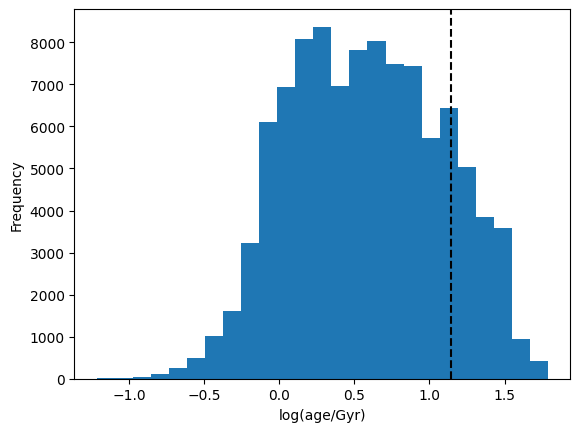

In [9]:
ax = df.log_age.plot(kind="hist", bins=25)
ax.axvline(np.log10(14), c="k", ls="--")
ax.set_xlabel("log(age/Gyr)");

In [10]:
truths_filepath = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/truths.json"
# SAVE TRUTHS
with open(truths_filepath, "r") as file:
    s = file.read()
    truths = json.loads(s)


In [11]:
# num_stars = 50
# hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]

# mask = np.less(truths["Teff"], 7500) & np.less(truths["age"], 14)
# truths = {key: np.array(value)[mask][:num_stars] if np.ndim(value) > 0 else value for key, value in truths.items()}
# truths["L"] = 10**truths["log_L"]

In [12]:
num_stars = 200

hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]
truths = {key: truths[key] for key in hyperparam_names}

rename_cols = {
    "EEP": "evol",
    "star_mass": "mass",
    "log_star_mass": "log_mass",
    "Yinit": "Y",
    "amlt": "a_MLT",
    "radius": "R",
    "log_radius": "log_R",
    "Dnu_freq_o": "Dnu",
    "log_Dnu_freq_o": "log_Dnu",
}

mask = (df.Teff < 7500.) & (df.age < 14.)
truths_ = df.loc[mask].iloc[:num_stars].rename(rename_cols, axis=1).to_dict(orient="list")
truths.update({key: np.array(value) for key, value in truths_.items()})

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [13]:
rng, key = random.split(rng)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "Teff": dict(scale=75.),
    # "log_g": dict(scale=0.1),
    "L": dict(scale=0.01*truths["L"])
}

# const["precision_Y"] = dict(concentration=1.0, rate=1e-4/3)
# Create model
model = HierarchicalStarModel(num_stars, const=const)

pprint(model.const)  # check all constants

{'L': {'scale': array([0.04590869, 0.05808464, 0.36328047, 0.00758569, 0.02371601,
       0.00659388, 0.10671636, 0.04157221, 0.01173688, 0.03321361,
       0.00315089, 0.0426172 , 0.03976888, 0.00494392, 0.0307967 ,
       0.0407358 , 0.00625876, 0.03593348, 0.00235962, 0.33011551,
       0.06139247, 0.19457778, 0.00779995, 0.08589941, 0.13388308,
       0.07920224, 0.06199447, 0.00884471, 0.16795069, 0.02312323,
       0.0064176 , 0.01912793, 0.1910389 , 0.07957236, 0.05663058,
       0.02689554, 0.18923477, 0.06180859, 0.05657057, 0.00226939,
       0.01505152, 0.11728618, 0.05974103, 0.12203122, 0.14844716,
       0.07093121, 0.01071711, 0.01004851, 0.00769669, 0.04363391,
       0.88207577, 0.14646157, 0.06968626, 0.01081117, 0.16613991,
       0.012037  , 0.04658845, 0.01469927, 0.02905776, 0.02493495,
       0.56786582, 0.02377802, 0.03814602, 0.03728478, 0.20666473,
       0.13905199, 0.0913842 , 0.21604576, 0.06350806, 0.33883916,
       0.11374379, 0.03365259, 0.05604795, 0.0

## Prior Predictive

Sample from the model prior.

In [14]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
with jax.default_device(gpu):
    prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [15]:
outputs = ["log_age", "log_Teff", "log_R", "log_Dnu"]
coords = {"star": np.arange(num_stars), "outputs": outputs}
dims = {}
for key, value in prior_samples.items():
    dims[key] = dim = []
    if value.ndim == 1:
        continue
    # if value.shape[1] == len(outputs):
    #     dim.append("outputs")
    if value.shape[-1] == num_stars:
        dim.append("star")

data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

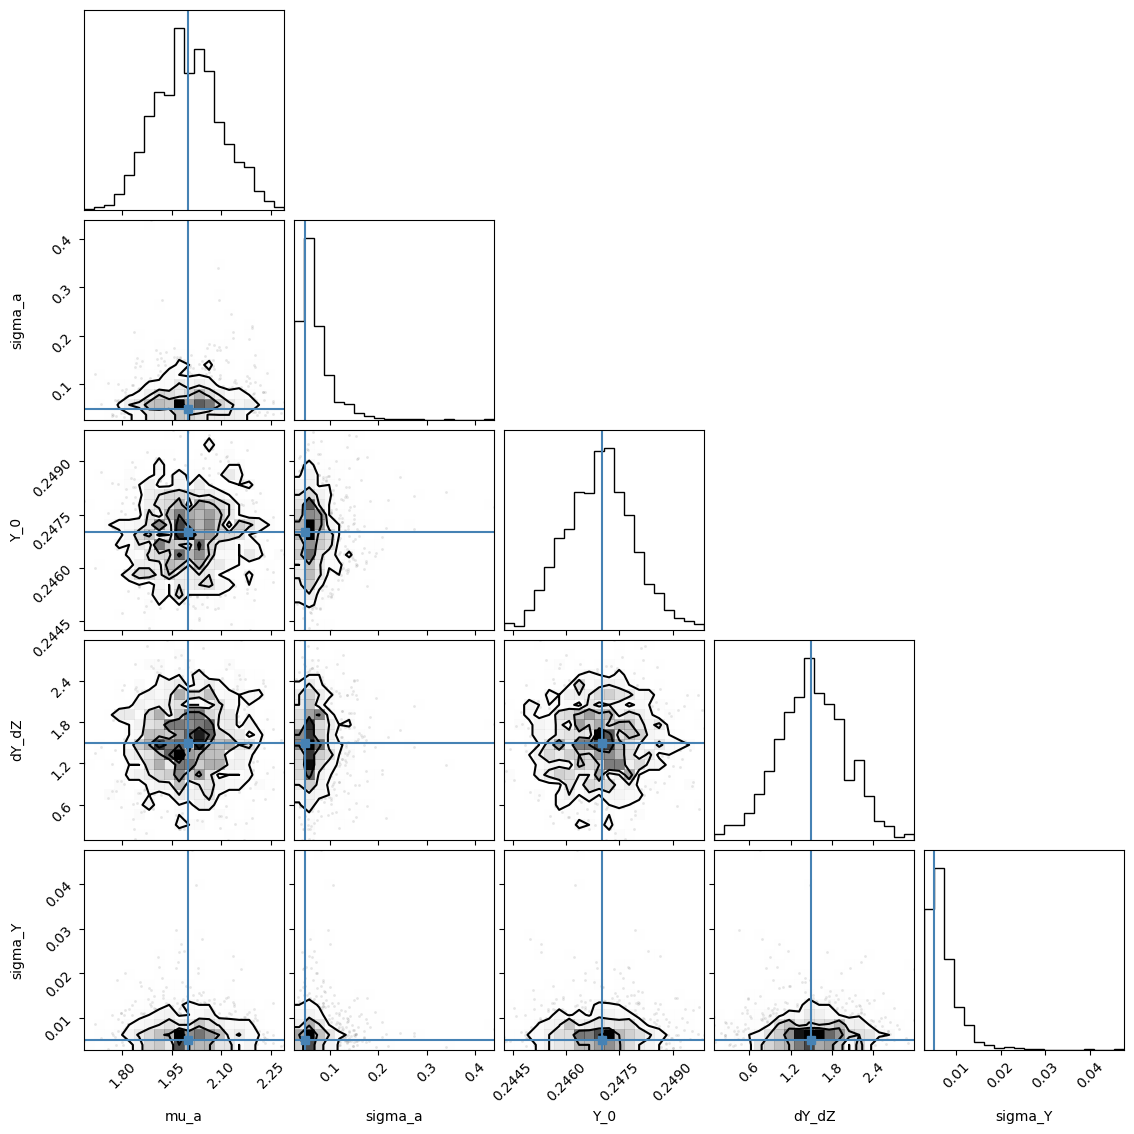

In [16]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

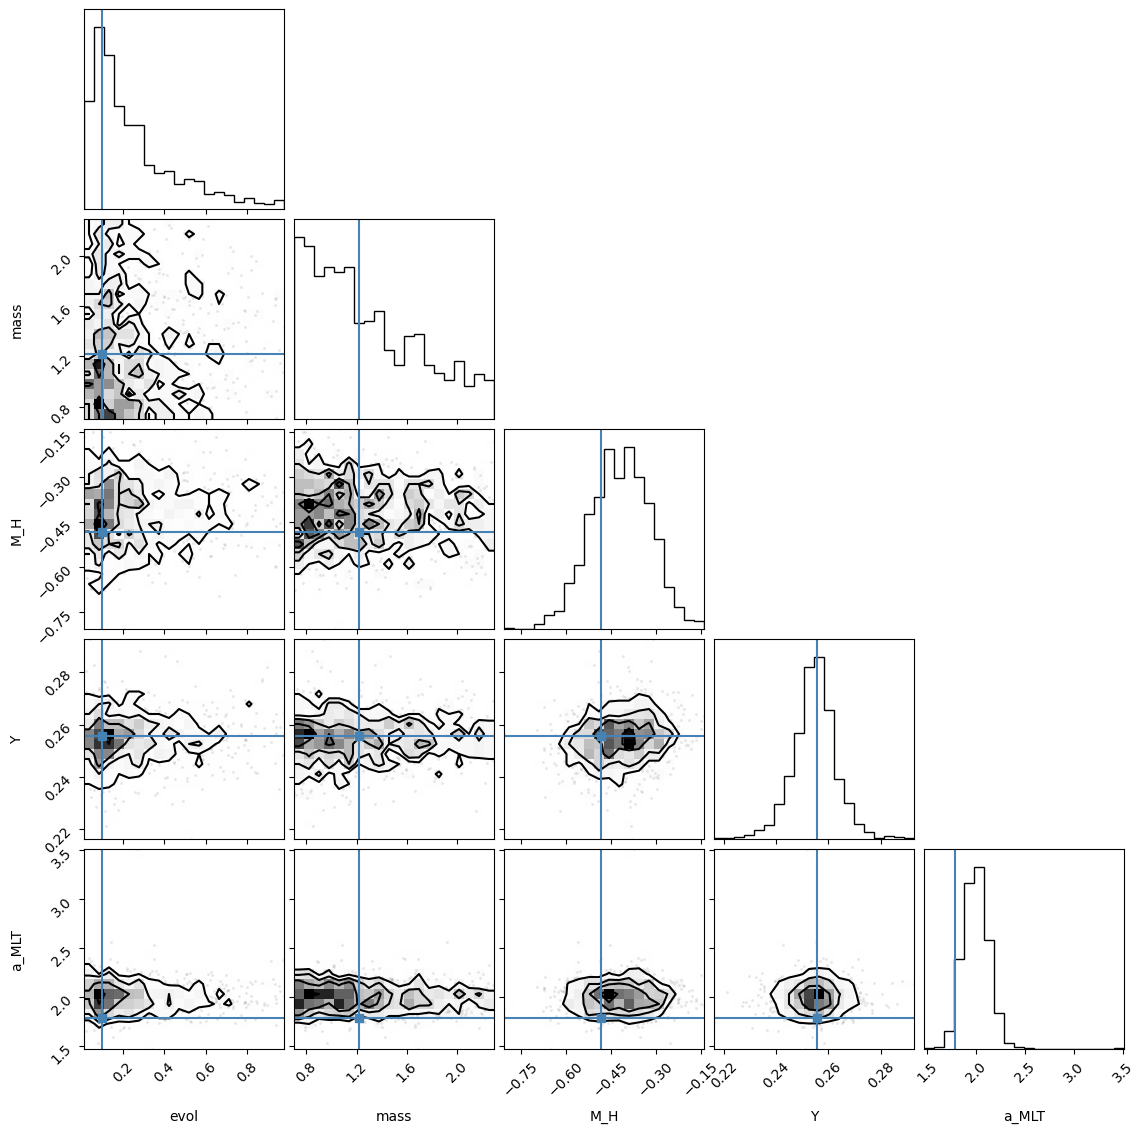

In [17]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

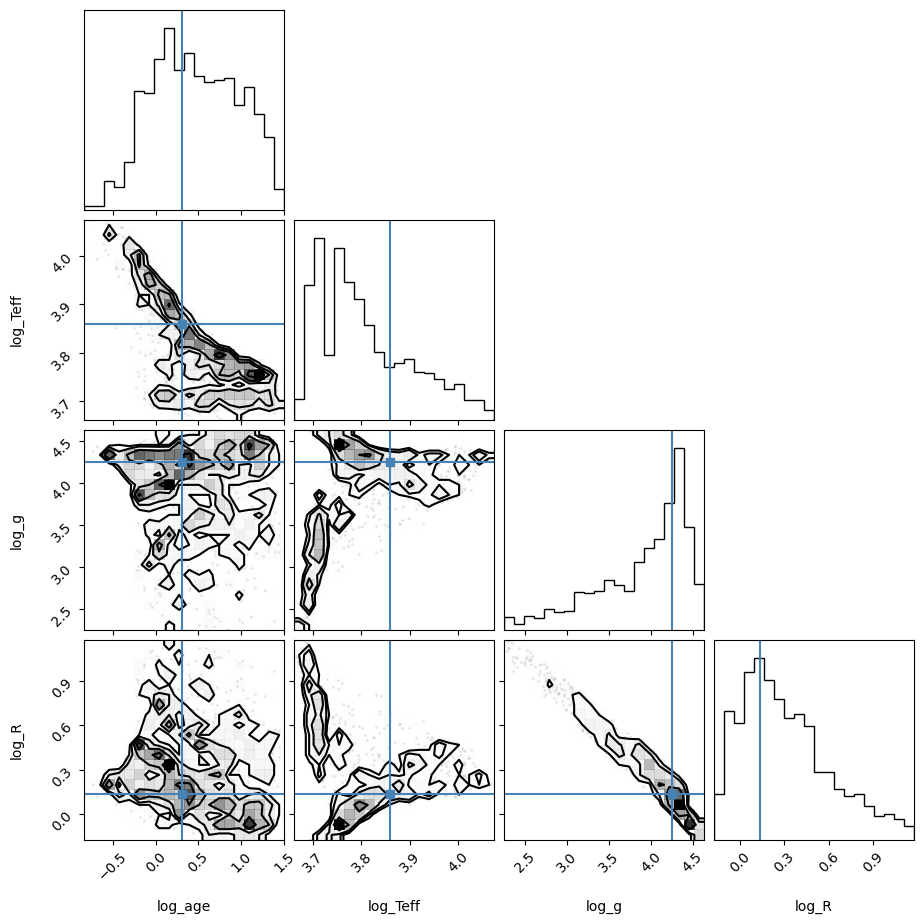

In [18]:
star = 0
var_names = ["log_age", "log_Teff", "log_g", "log_R"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

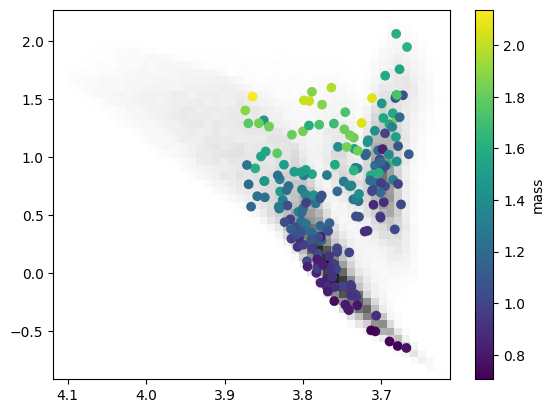

In [19]:
fig, ax = plt.subplots()

ax.hist2d(data.prior.log_Teff.values.ravel(), data.prior.log_L.values.ravel(), bins=50, cmap="Grays")
s = ax.scatter(truths["log_Teff"], truths["log_L"], c=truths["mass"])
ax.invert_xaxis()
fig.colorbar(s, label="mass");

## Observation

Now we synthesize observable parameters for the model.

In [20]:
rng, *keys = random.split(rng, 3)
obs = {
    "Teff": truths["Teff"] + const["Teff"]["scale"] * random.normal(keys[0], shape=truths["Teff"].shape),
    # "log_g": truths["log_g"] + const["log_g"]["scale"] * random.normal(keys[1], shape=truths["log_g"].shape),
    "L": truths["L"] + const["L"]["scale"] * random.normal(keys[1], shape=truths["log_L"].shape),
}
pprint(obs)

{'L': Array([  4.56427666,   5.7593397 ,  36.11277567,   0.75299625,
         2.39493059,   0.65861539,  10.65113857,   4.13832727,
         1.1827891 ,   3.32503991,   0.31659123,   4.25466702,
         3.99525633,   0.49301906,   3.04068178,   4.09810685,
         0.62039215,   3.63162859,   0.2355126 ,  33.71660895,
         6.1231601 ,  19.08880331,   0.77685367,   8.62732726,
        13.2781901 ,   8.04595937,   6.25532268,   0.87744762,
        16.8064853 ,   2.32897571,   0.65213679,   1.93672182,
        19.48481682,   7.88092203,   5.65636095,   2.72999941,
        18.73840466,   6.12547652,   5.67765493,   0.22762937,
         1.52078013,  11.78016879,   5.97064147,  12.01168403,
        14.8594933 ,   7.10956388,   1.04727083,   0.99649018,
         0.77773481,   4.31188011,  86.64741005,  14.57001991,
         7.00493267,   1.07652398,  16.45469702,   1.20995038,
         4.70659599,   1.46445932,   2.84733156,   2.51023286,
        56.6705882 ,   2.3788908 ,   3.81008776, 

In [21]:
# obs = np.stack([obs[key] for key in ["Teff", "L"]], -1)
# obs

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [22]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
# sampler = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median, find_heuristic_step_size=True, max_tree_depth=11)
sampler = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(sampler, num_warmup=4000, num_samples=2000, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [23]:
rng, key = random.split(rng)
start = time()
# with jax.default_device(gpu):
    # mcmc.run(key, obs=obs)
mcmc.run(key, obs=obs)
elapsed_time = time() - start
mcmc.print_summary()

sample: 100%|████████████████████████| 6000/6000 [1:51:04<00:00,  1.11s/it, 1023 steps of size 1.12e-03. acc. prob=0.93]



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
               M_H[0]     -0.40      0.10     -0.40     -0.57     -0.25     73.15      1.02
               M_H[1]     -0.67      0.09     -0.68     -0.83     -0.53     56.38      1.00
               M_H[2]     -0.58      0.11     -0.58     -0.76     -0.40     72.38      1.00
               M_H[3]      0.14      0.09      0.14     -0.01      0.29    137.97      1.01
               M_H[4]      0.15      0.09      0.15      0.01      0.30    162.27      1.00
               M_H[5]      0.32      0.06      0.33      0.22      0.40    253.15      1.01
               M_H[6]     -0.75      0.08     -0.76     -0.89     -0.64    164.90      1.02
               M_H[7]      0.16      0.09      0.16     -0.00      0.30    108.95      1.02
               M_H[8]     -0.69      0.10     -0.69     -0.87     -0.54     70.64      1.00
               M_H[9]     -0.02      0.10     -0.02     -0.18      0.12     70.

In [24]:
elapsed_time / 60 / 60

1.856157527897093

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [25]:
with jax.default_device(gpu):
    data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

In [28]:
summary = az.summary(data, fmt="xarray")
summary

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


<xarray.Dataset>
Dimensions:           (star: 100, metric: 9)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/30)
    Dnu               (metric, star) float64 85.65 76.88 14.28 ... nan nan nan
    L                 (metric, star) float64 4.597 5.935 36.31 ... nan nan nan
    M_H               (metric, star) float64 -0.4288 -0.6751 -0.5597 ... nan nan
    R                 (metric, star) float64 1.388 1.463 5.526 ... nan nan nan
    Teff              (metric, star) float64 7.175e+03 7.45e+03 ... nan nan
    Y                 (metric, star) float64 0.2564 0.2536 0.2548 ... nan nan
    ...                ...
    numax             (metric, star) float64 1.778e+03 1.51e+03 ... nan nan
    precision_Y       (metric) float64 3.16e+04 2.162e+04 2.29e+03 ... 94.77 nan
    precision_a       (metric) float64 337.4 200.6 42.52 ... 227.9 318.4 nan
    scaled_precision  (metric, star) float64 1.1 0.9755 1.036 ... nan nan nan
    sigma_Y           (metric) float64 0.006818 0.002815 0.002915 ... 94.77 nan
    sigma_a           (metric) float64 0.06252 0.02085 0.03078 ... 318.4 nan

In [27]:
summary_nan = summary.where(summary.sel(metric="r_hat") < 1.1).to_array()
summary_nan

<xarray.DataArray (variable: 30, metric: 9, star: 50)>
array([[[ 8.30917040e+01,  7.56111695e+01,  1.51063597e+01, ...,
          1.45150975e+02,  1.31492332e+02,  6.48616536e+01],
        [ 3.26947286e+00,  2.72566429e+00,  4.83078320e-01, ...,
          7.18075646e+00,  9.01302962e+00,  2.42261074e+00],
        [ 7.68865109e+01,  7.03232594e+01,  1.41957920e+01, ...,
          1.31582452e+02,  1.14916721e+02,  5.96642306e+01],
        ...,
        [ 4.12548751e+03,  3.97828237e+03,  3.92749755e+03, ...,
          2.92697317e+03,  3.27767581e+03,  1.60980917e+03],
        [ 6.02988674e+03,  6.09991922e+03,  6.32416797e+03, ...,
          3.17350115e+03,  4.47352496e+03,  4.92170949e+03],
        [ 1.00074416e+00,  1.00058683e+00,  1.00240969e+00, ...,
          1.00064520e+00,  1.00212906e+00,  1.00162638e+00]],

       [[ 4.69929494e+00,  5.83496214e+00,  3.64199106e+01, ...,
          1.00714574e+00,  7.82863927e-01,  4.40433098e+00],
        [ 7.08991997e-02,  8.93210365e-02,  5.57912193e-01, ...,
          1.49054840e-02,  1.20898993e-02,  6.75609534e-02],
        [ 4.56889729e+00,  5.67461115e+00,  3.53999277e+01, ...,
          9.78443045e-01,  7.61184788e-01,  4.27687761e+00],
...
        [ 4.08827364e+03,  4.08827364e+03,  4.08827364e+03, ...,
          4.08827364e+03,  4.08827364e+03,  4.08827364e+03],
        [ 3.11280833e+03,  3.11280833e+03,  3.11280833e+03, ...,
          3.11280833e+03,  3.11280833e+03,  3.11280833e+03],
        [ 1.00386279e+00,  1.00386279e+00,  1.00386279e+00, ...,
          1.00386279e+00,  1.00386279e+00,  1.00386279e+00]],

       [[ 6.87248966e-02,  6.87248966e-02,  6.87248966e-02, ...,
          6.87248966e-02,  6.87248966e-02,  6.87248966e-02],
        [ 2.73113351e-02,  2.73113351e-02,  2.73113351e-02, ...,
          2.73113351e-02,  2.73113351e-02,  2.73113351e-02],
        [ 3.16631310e-02,  3.16631310e-02,  3.16631310e-02, ...,
          3.16631310e-02,  3.16631310e-02,  3.16631310e-02],
        ...,
        [ 1.28359334e+03,  1.28359334e+03,  1.28359334e+03, ...,
          1.28359334e+03,  1.28359334e+03,  1.28359334e+03],
        [ 1.42351695e+03,  1.42351695e+03,  1.42351695e+03, ...,
          1.42351695e+03,  1.42351695e+03,  1.42351695e+03],
        [ 1.01450836e+00,  1.01450836e+00,  1.01450836e+00, ...,
          1.01450836e+00,  1.01450836e+00,  1.01450836e+00]]])
Coordinates:
  * star      (star) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * metric    (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
  * variable  (variable) object 'Dnu' 'L' 'M_H' ... 'sigma_Y' 'sigma_a'

In [28]:
summary_stacked = summary_nan.stack(x=["variable", "metric", "star"])
null_coords = summary_stacked[summary_stacked.isnull()].coords
bad_stars = set(null_coords["star"].values)
print(bad_stars)

{36}


In [29]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [30]:
efficiency

<xarray.Dataset>
Dimensions:           (star: 50)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
    metric            <U9 'ess_bulk'
Data variables: (12/30)
    Dnu               (star) float64 0.989 0.9537 0.9415 ... 0.7857 0.3859
    L                 (star) float64 2.416 2.429 2.303 2.3 ... 2.374 2.385 2.358
    M_H               (star) float64 0.574 0.5341 0.7938 ... 1.074 0.8134 0.6071
    R                 (star) float64 2.365 2.858 2.402 ... 0.8995 1.802 1.054
    Teff              (star) float64 2.438 2.641 2.23 ... 0.8726 1.748 1.243
    Y                 (star) float64 0.5415 0.33 0.4543 ... 0.1075 0.03898
    ...                ...
    numax             (star) float64 0.815 0.7348 1.128 ... 0.6575 0.6312 0.3346
    precision_Y       float64 0.9801
    precision_a       float64 0.3077
    scaled_precision  (star) float64 1.558 1.684 1.319 ... 1.369 1.552 1.474
    sigma_Y           float64 0.9801
    sigma_a           float64 0.3077

In [31]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

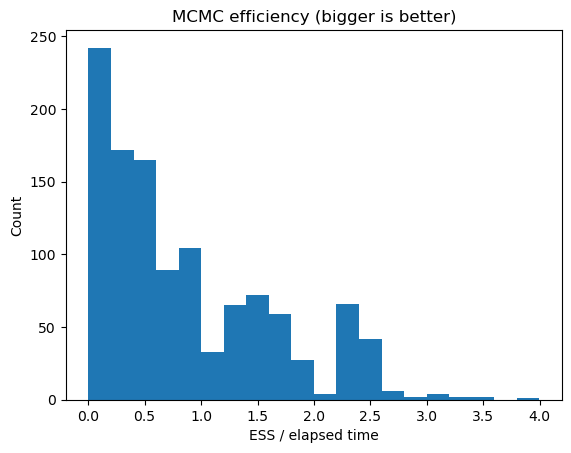

In [32]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

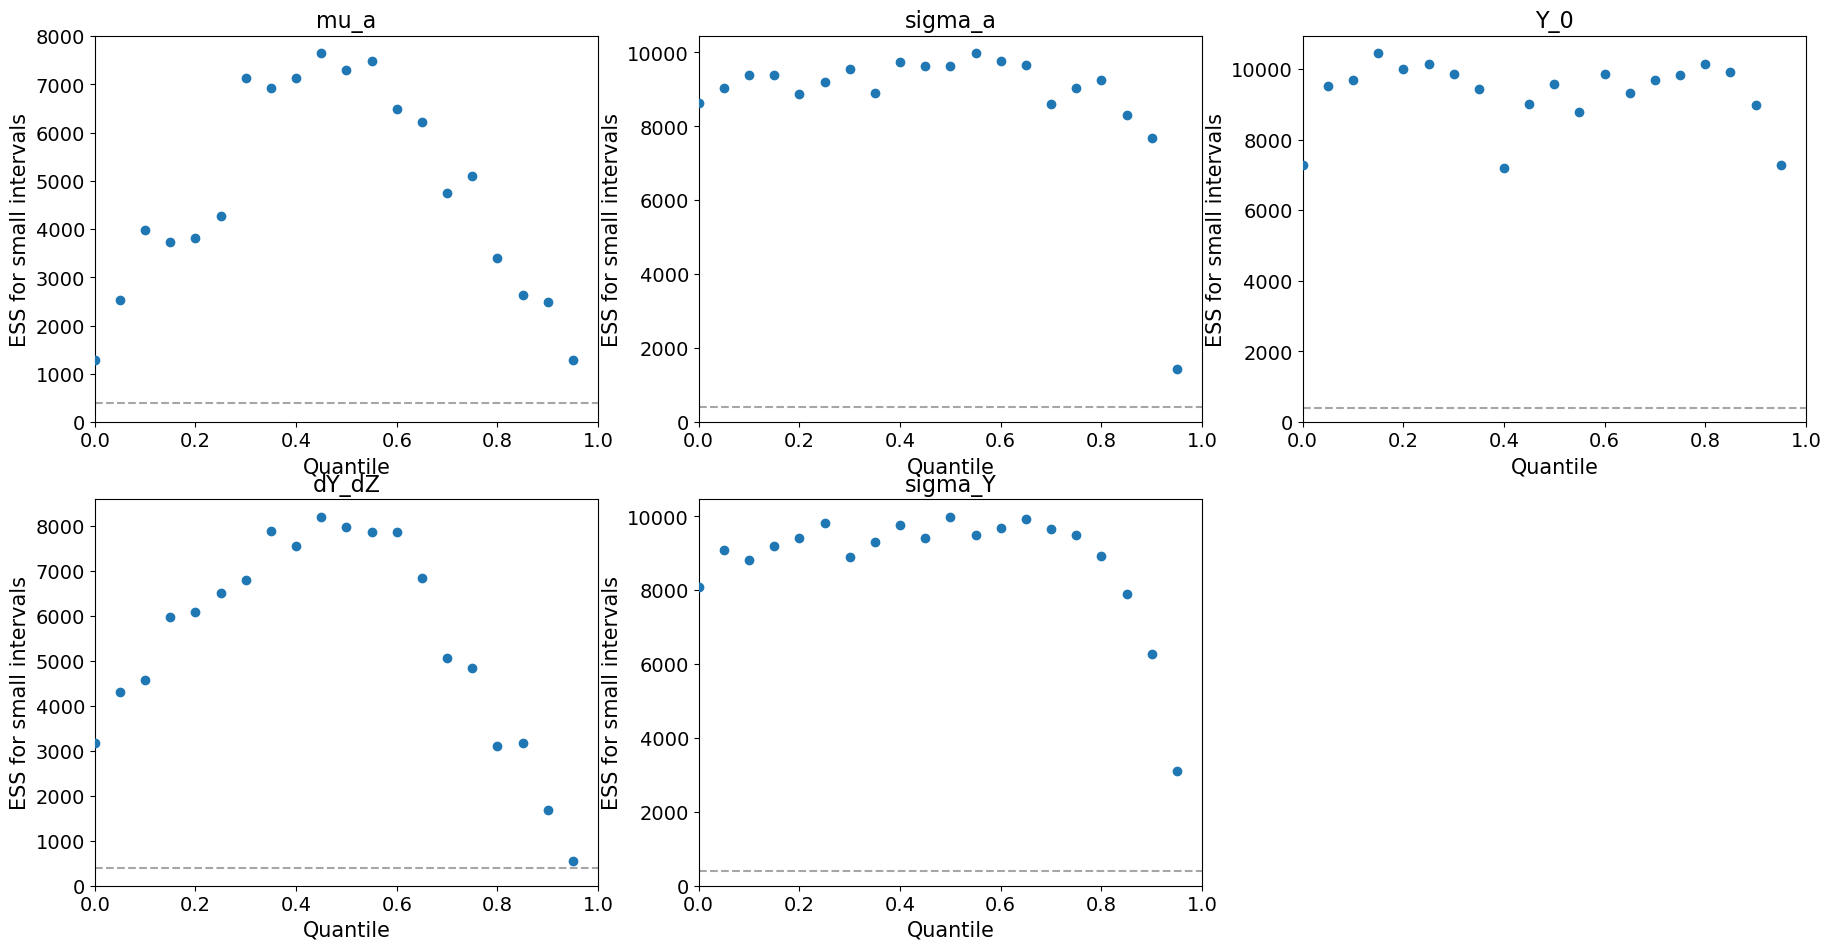

In [33]:
az.plot_ess(data, var_names=hyperparam_names);

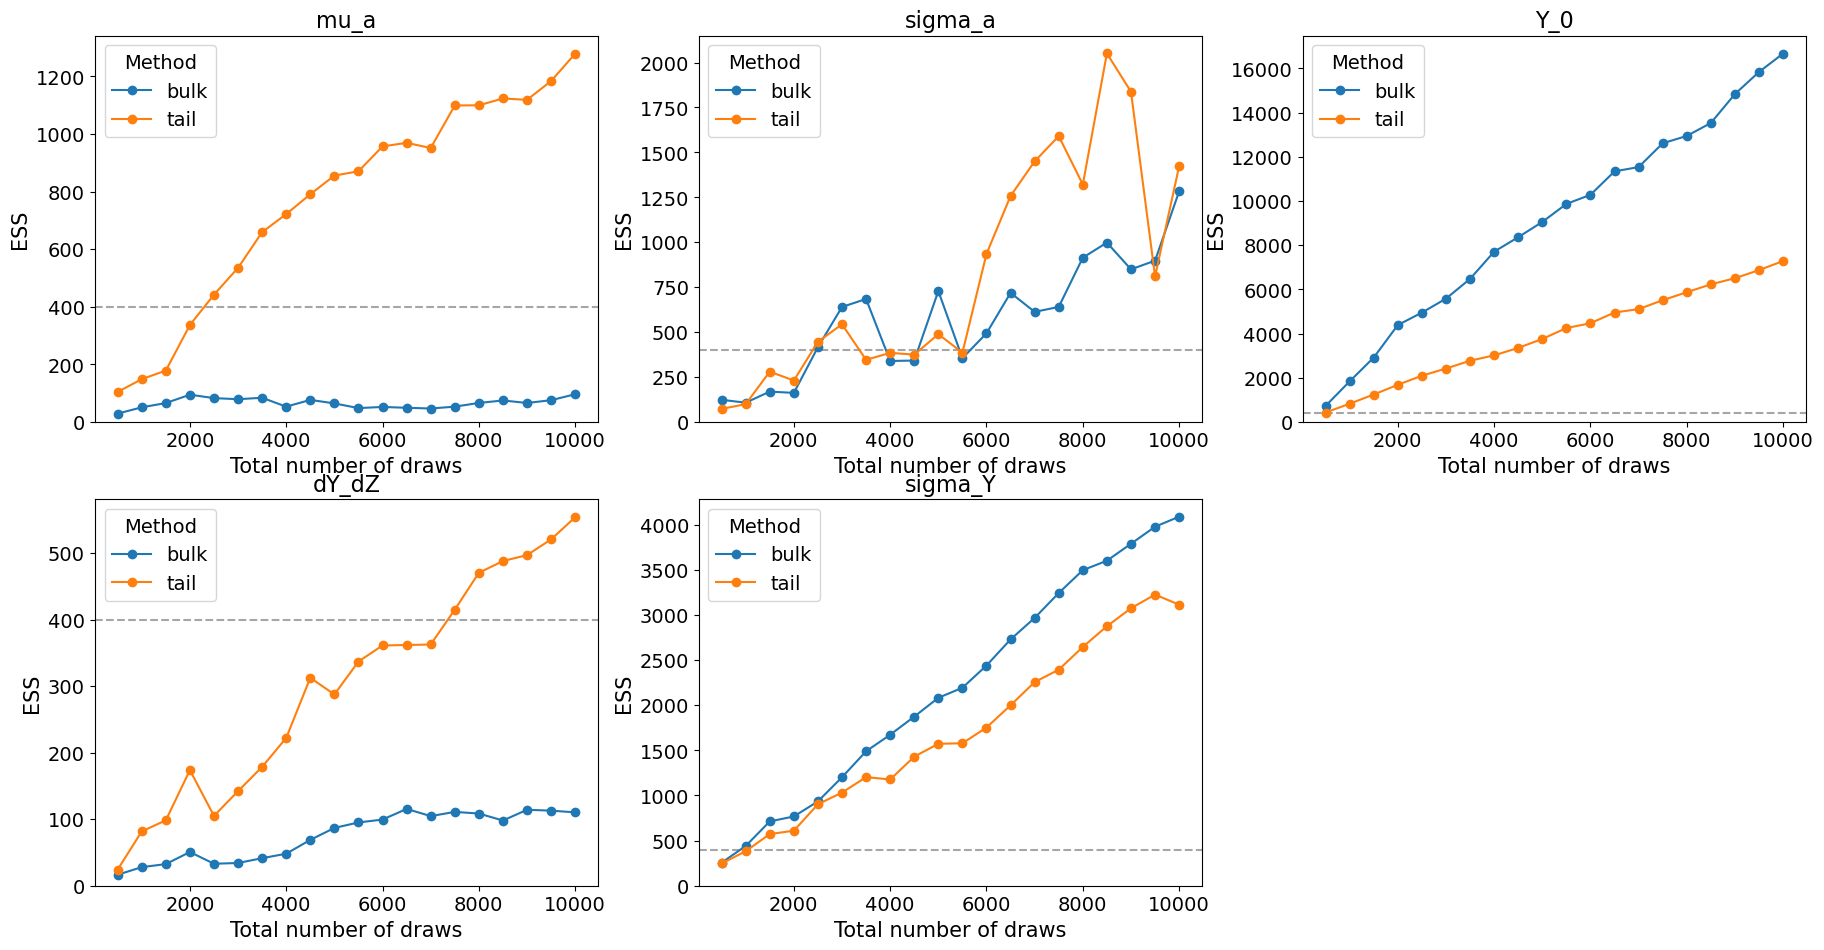

In [34]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

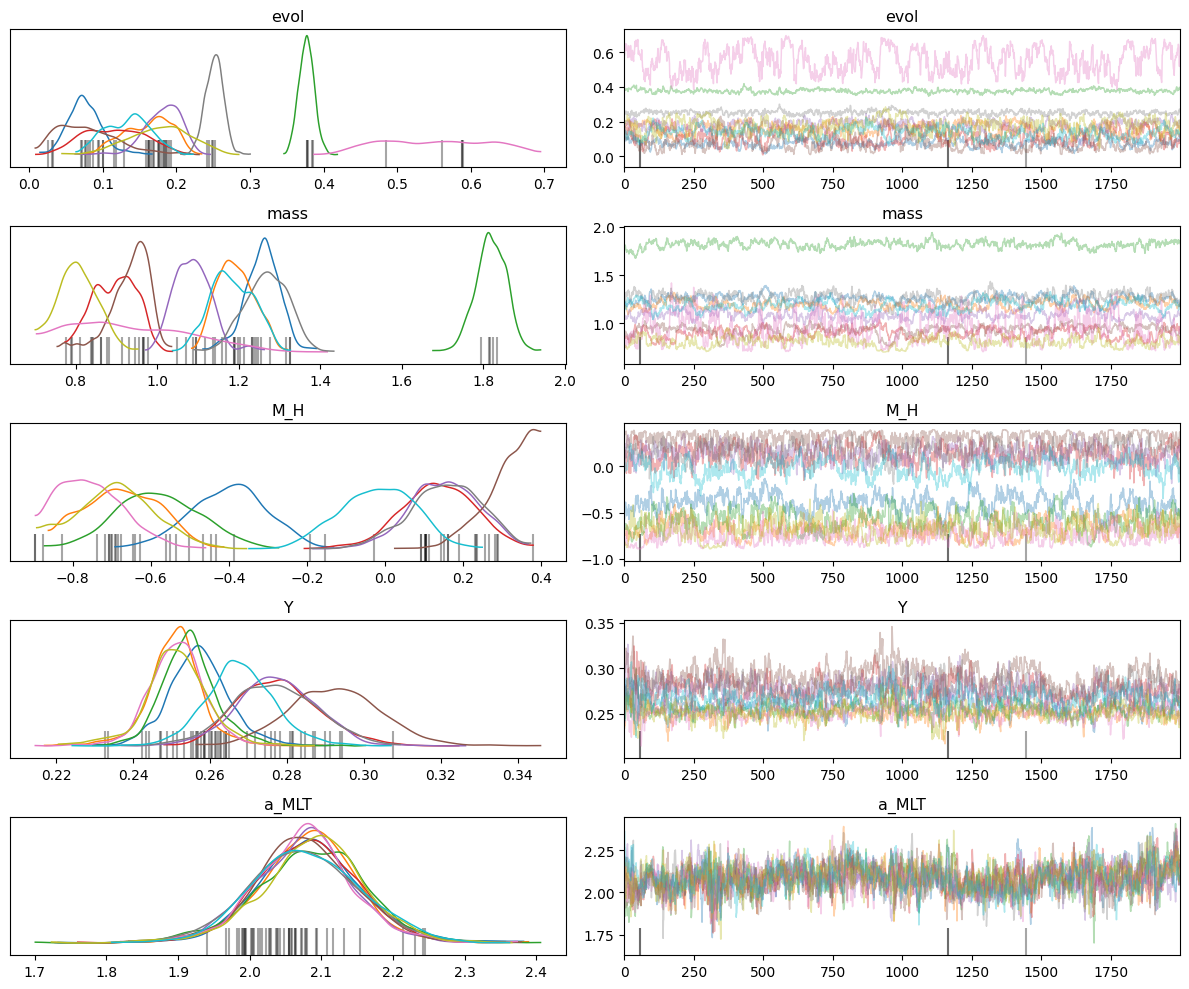

In [26]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(min(num_stars, 10))))
# az.plot_trace(data, var_names=var_names, coords=dict(star=good_stars[:10]))
plt.tight_layout()

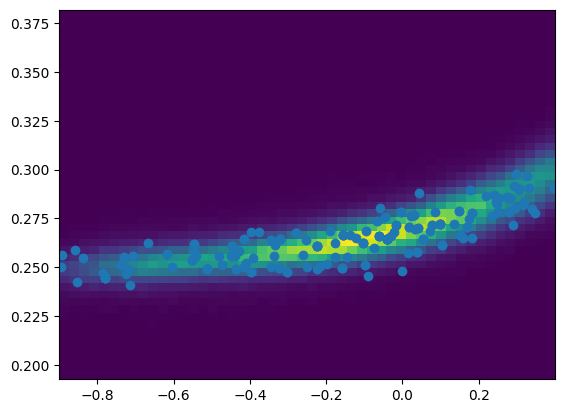

In [27]:
mh = data.posterior.M_H.values.flatten()
y = data.posterior.Y.values.flatten()
plt.hist2d(mh, y, bins=50)
plt.scatter(truths["M_H"], truths["Y"]);

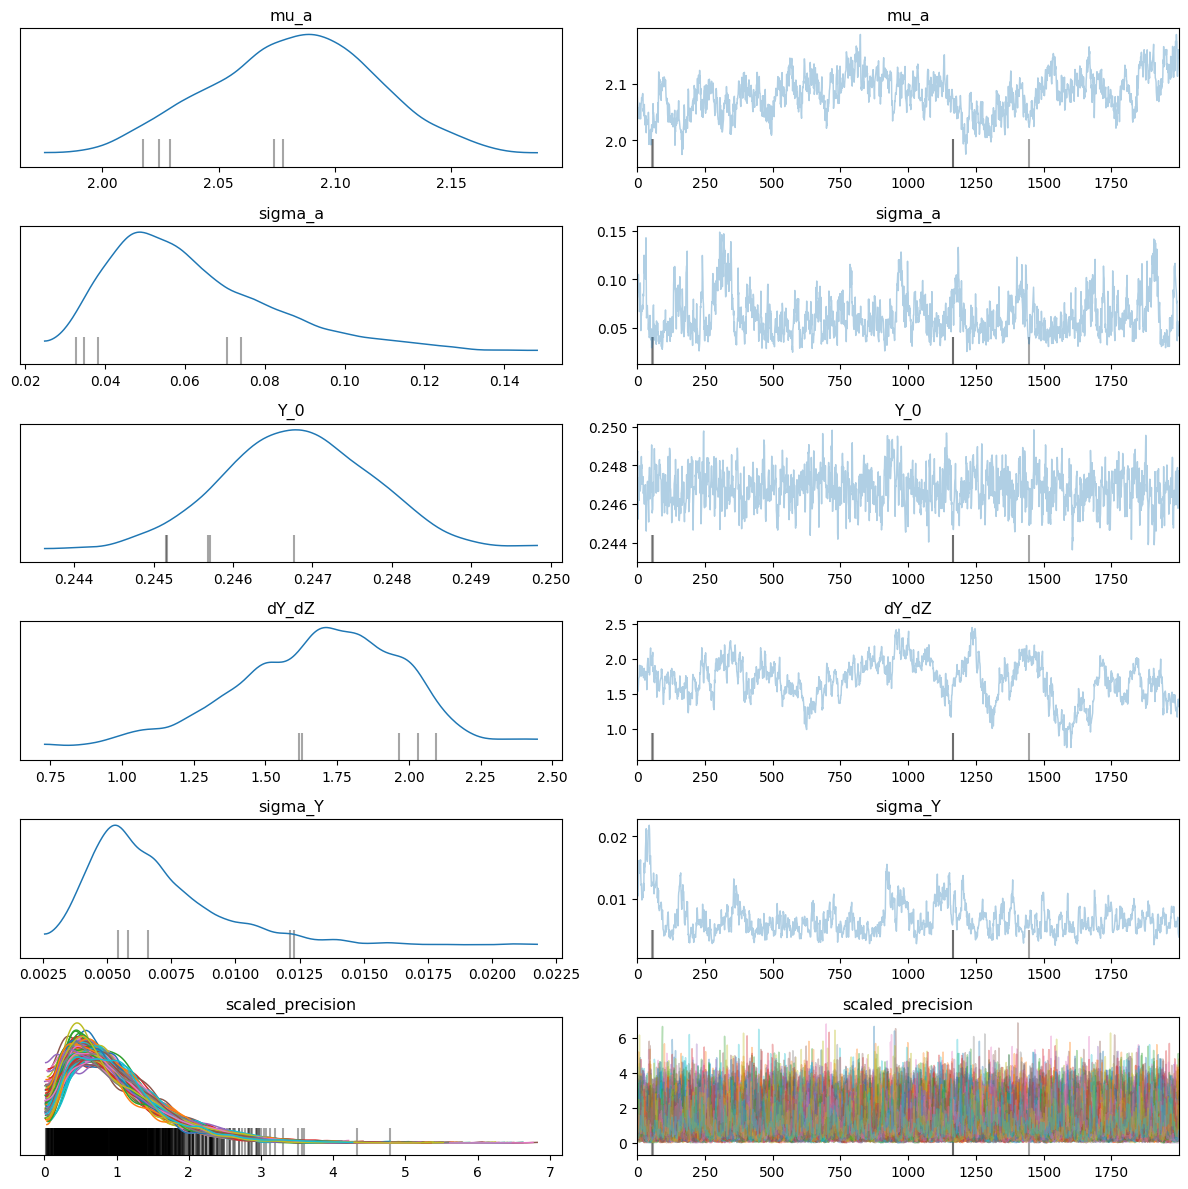

In [28]:
az.plot_trace(data, var_names=hyperparam_names+["scaled_precision"])
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

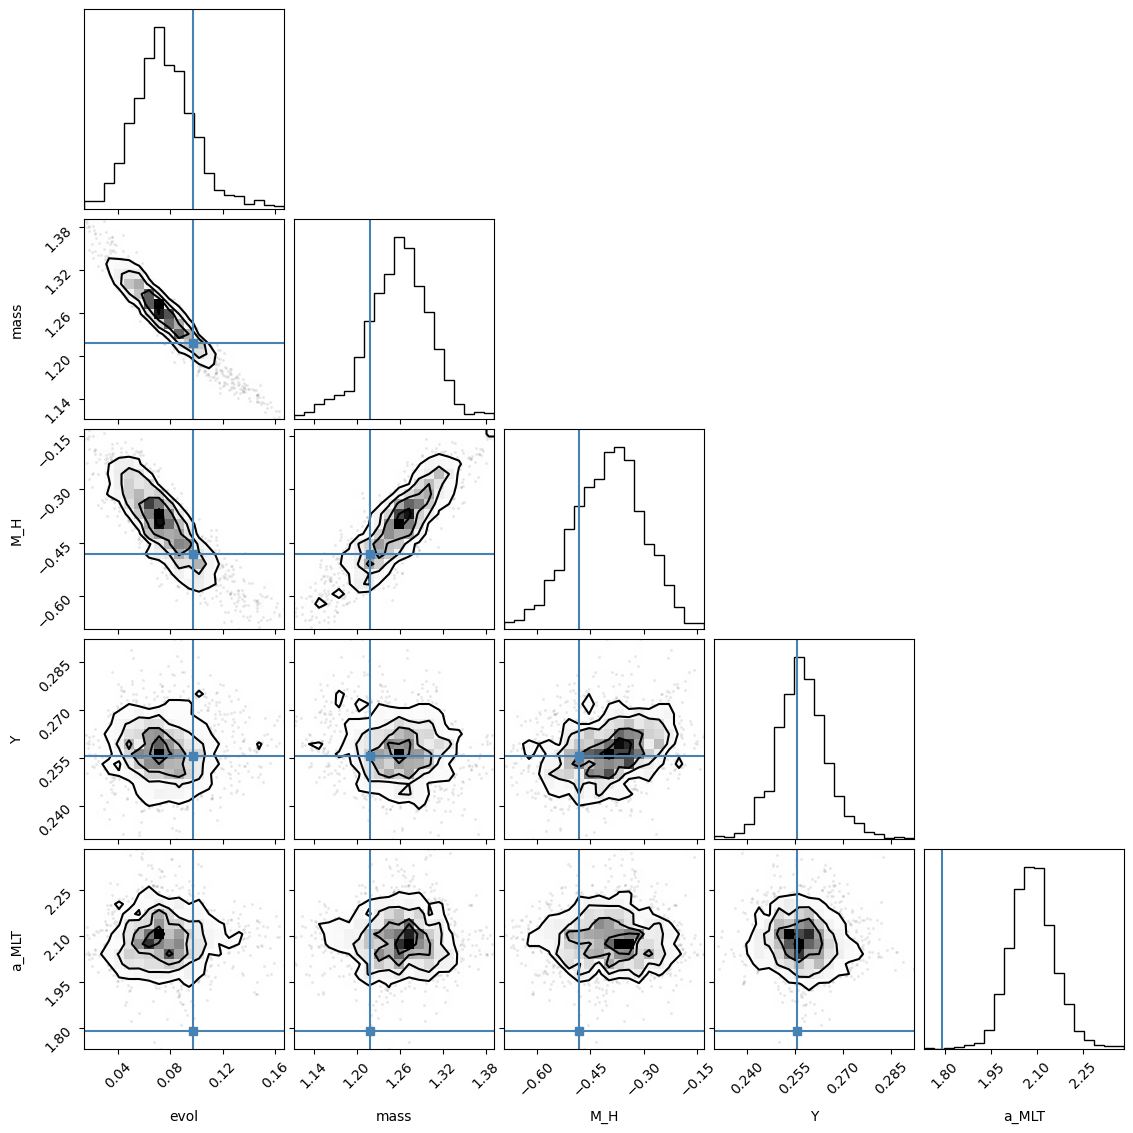

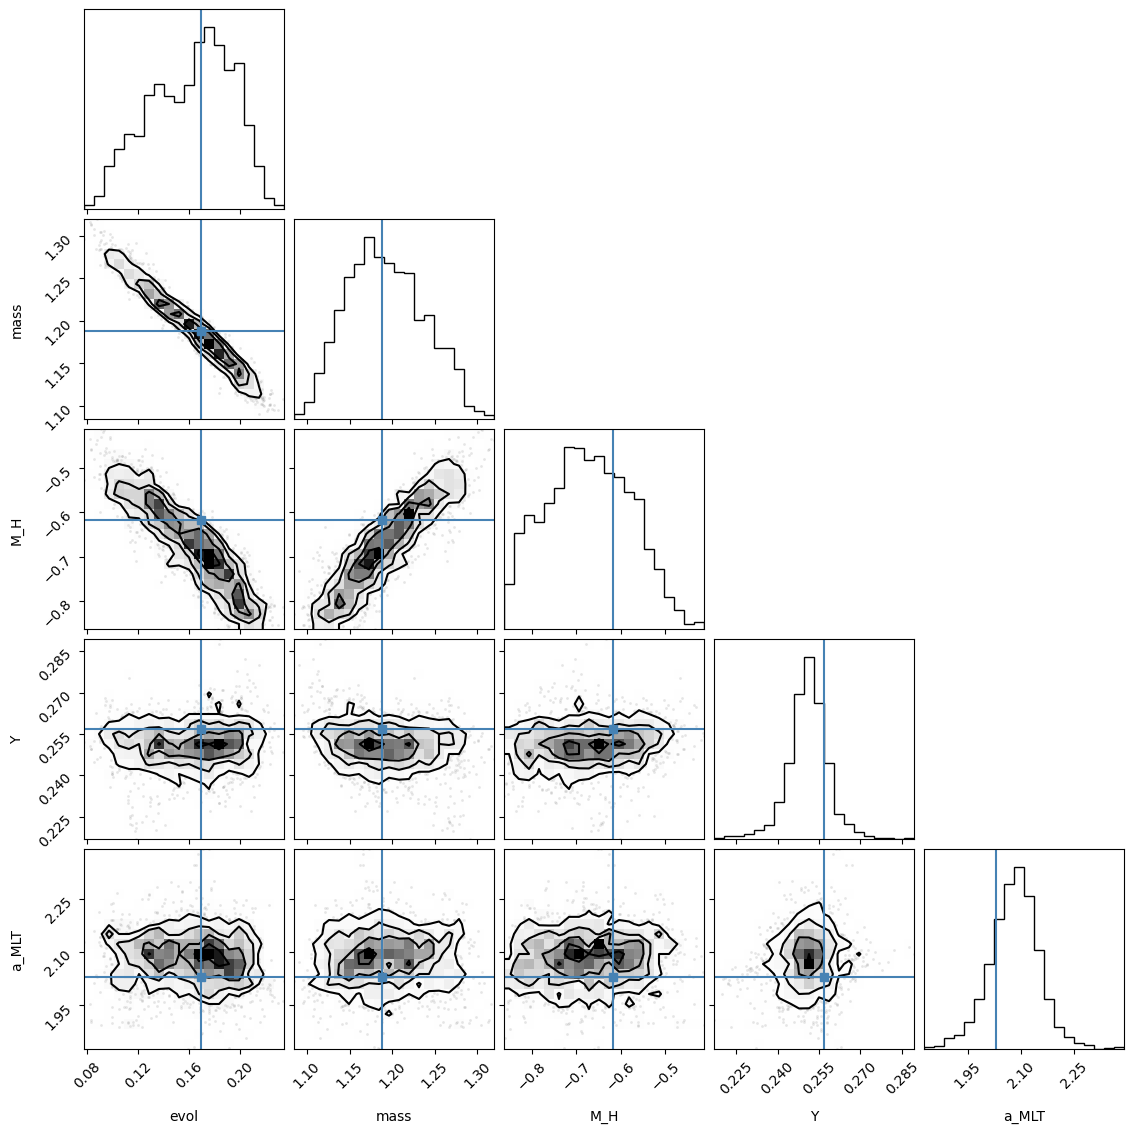

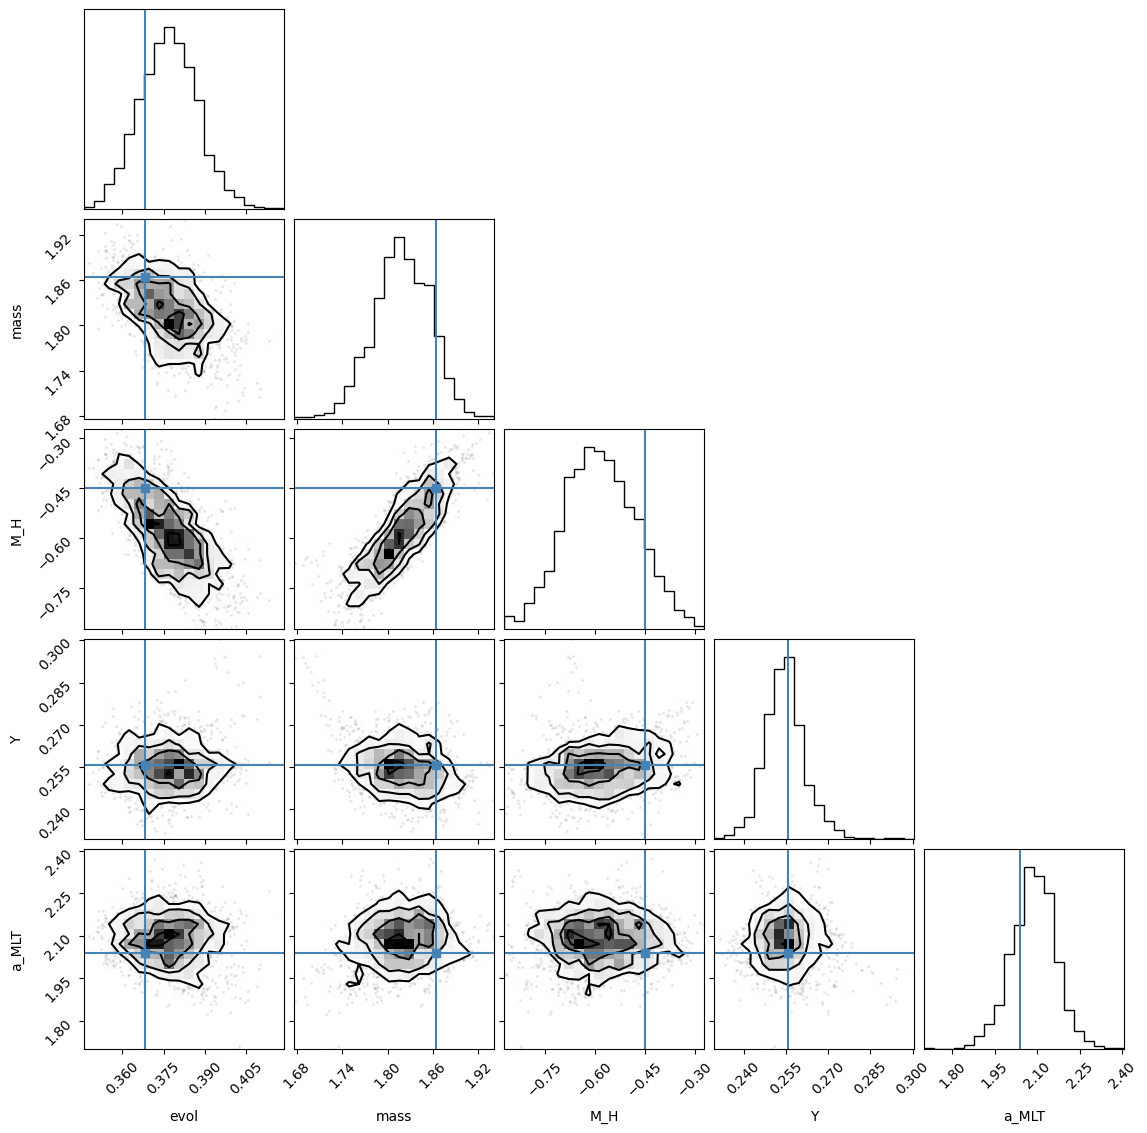

In [29]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

What do we predict for some deterministics?

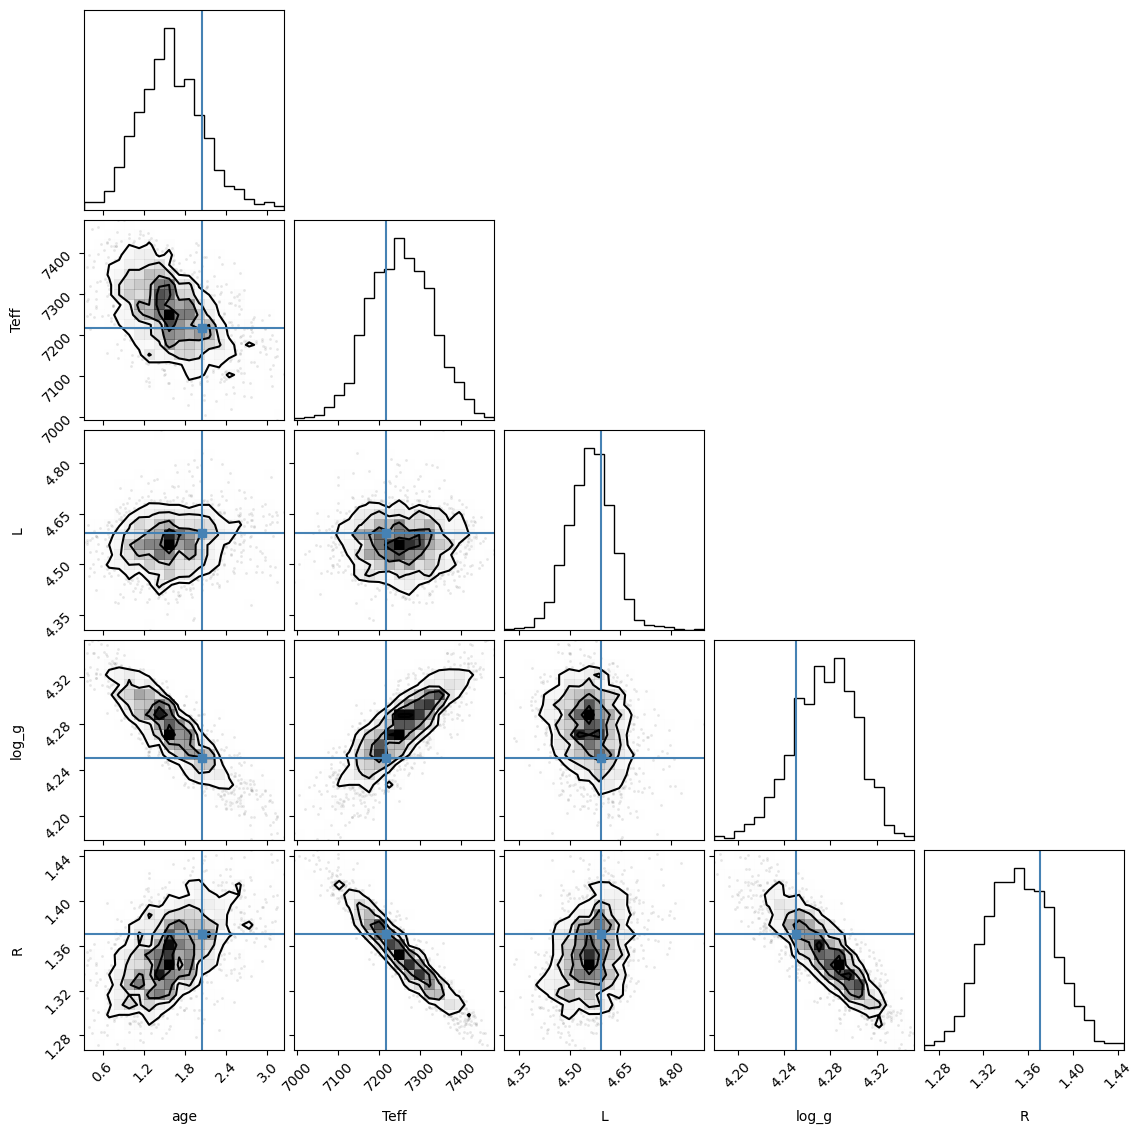

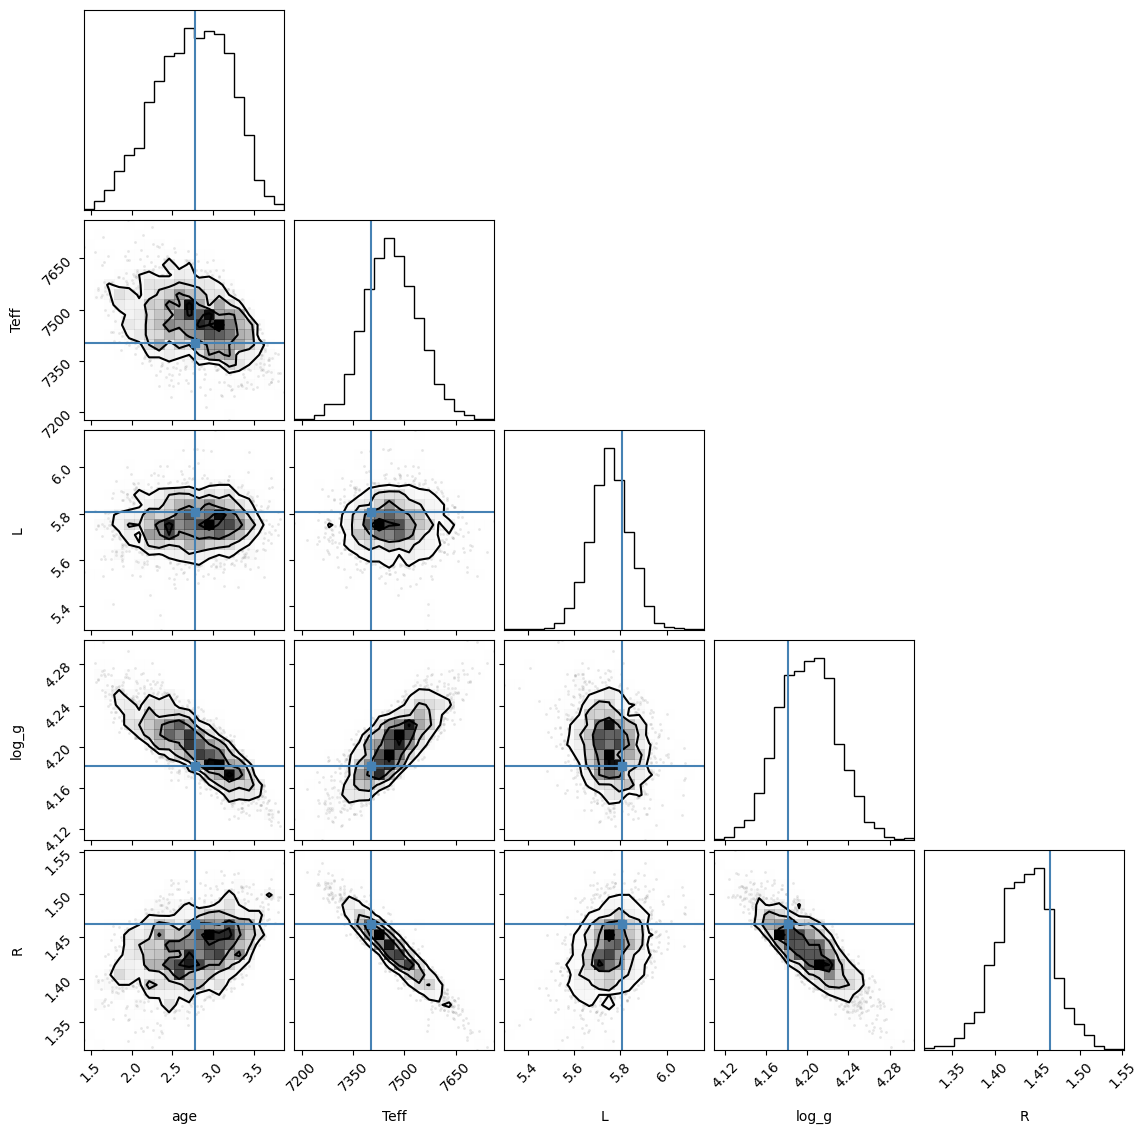

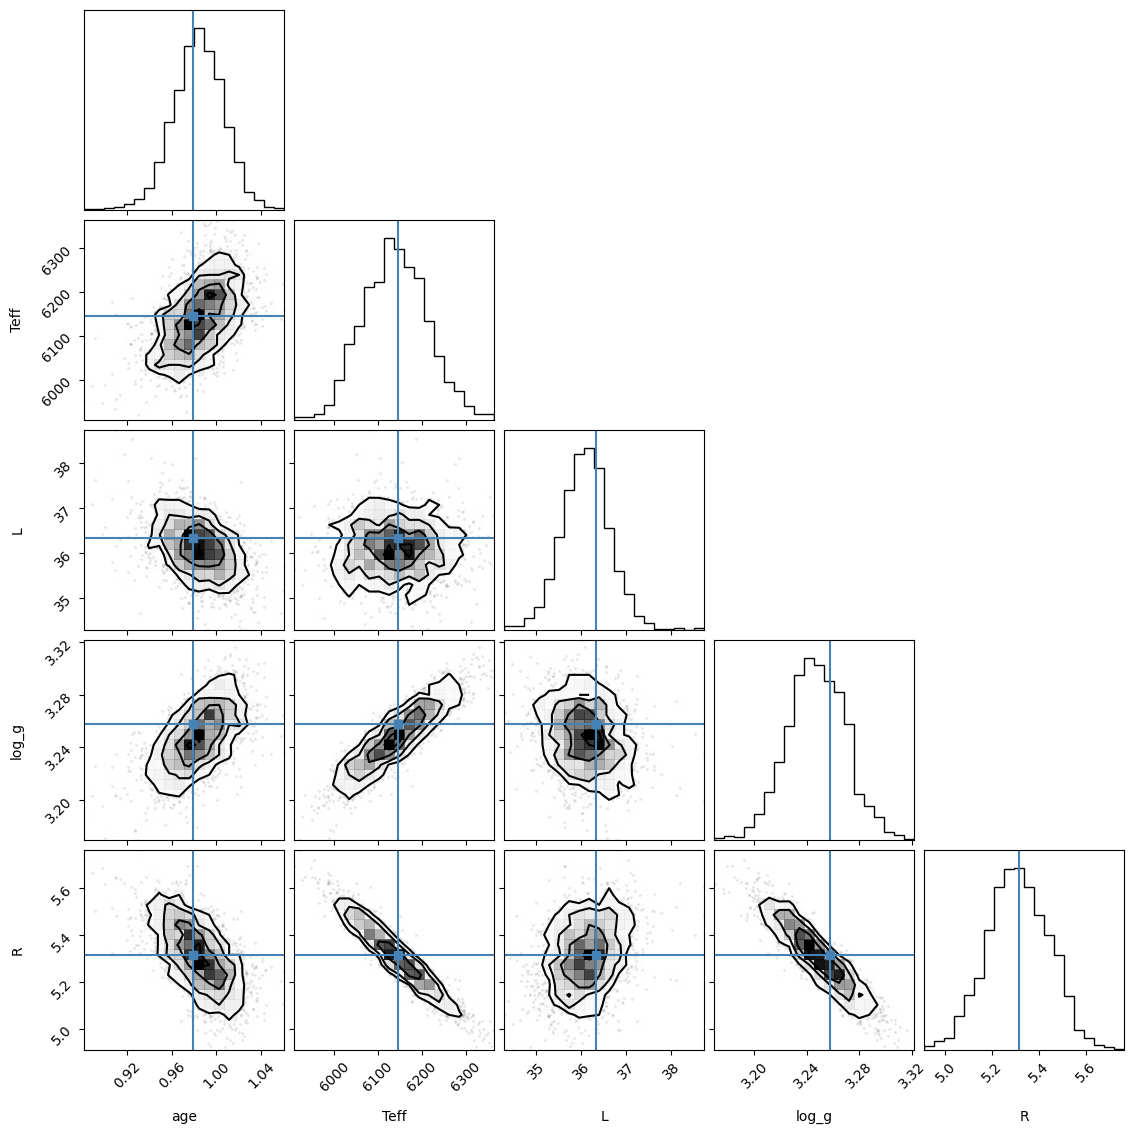

In [30]:
var_names = ["age", "Teff", "L", "log_g", "R"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

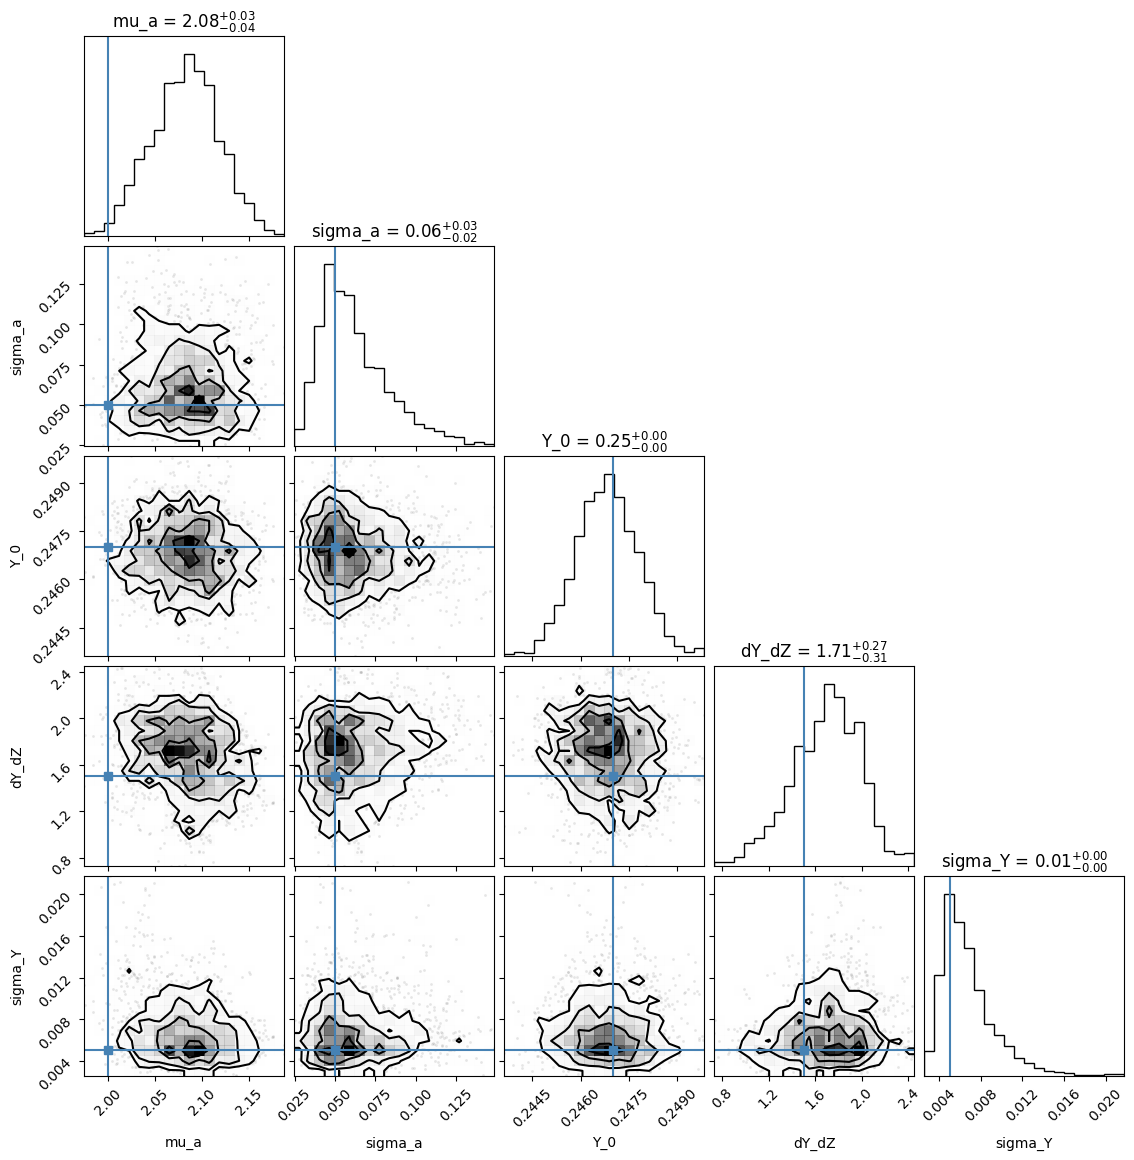

In [31]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths, show_titles=True)

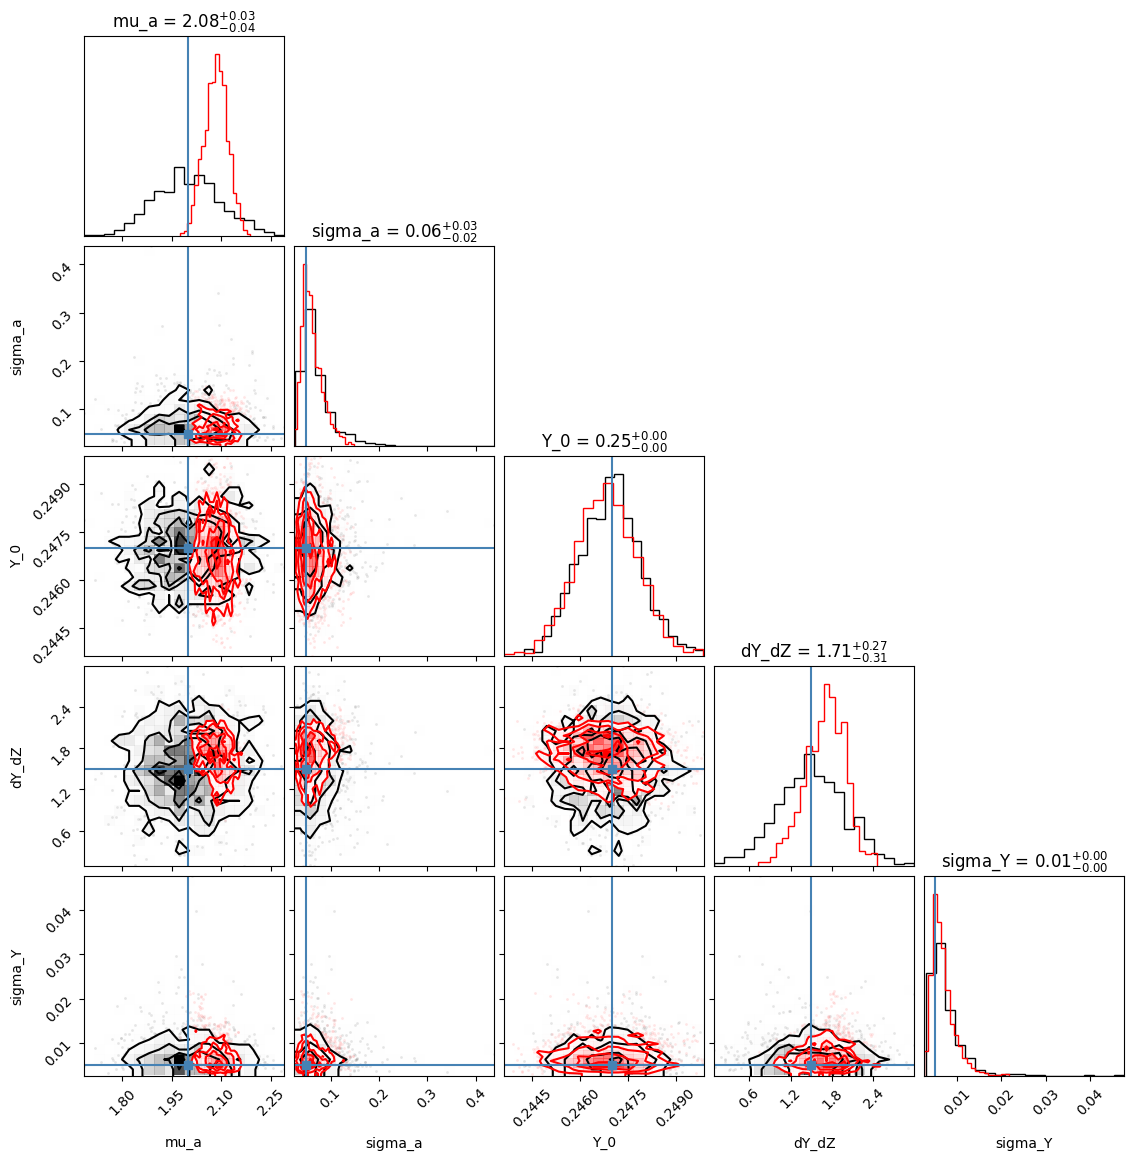

In [33]:
# limits = [(1.5, 2.5), (0.0, 0.4), (0.244, 0.250), (0.0, 3.0), (0.0, 0.04)]
limits = None
hist_kwargs = dict(density=True)
fig = corner(data, group="prior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs)

hist_kwargs["color"] = "r"
fig = corner(data, group="posterior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs,
             color="r", truths=truths, show_titles=True, fig=fig)


Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [35]:
mu_a = truths["a_MLT"].mean()
sigma_a = truths["a_MLT"].std(ddof=1)
error_on_mu = sigma_a / np.sqrt(num_stars)
print(mu_a, sigma_a, error_on_mu)

1.99028098 0.07302889548231536 0.010327845443621763


In [36]:
error = truths - data.posterior
az.summary(error)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Dnu[0]   -3.058  3.304  -9.710    2.986      0.080    0.064    1701.0   
Dnu[1]    1.052  2.623  -4.312    5.638      0.065    0.054    1599.0   
Dnu[2]   -0.486  0.451  -1.435    0.281      0.012    0.008    1442.0   
Dnu[3]   -7.157  6.679 -18.454    5.830      0.162    0.120    1736.0   
Dnu[4]    0.725  4.137  -7.076    8.093      0.133    0.094    1016.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[48]  0.101  0.065  -0.015    0.222      0.002    0.001    1144.0   
mass[49] -0.081  0.067  -0.201    0.032      0.003    0.003     409.0   
mu_a     -0.262  0.124  -0.486   -0.058      0.011    0.008     125.0   
sigma_Y  -0.001  0.002  -0.005    0.002      0.000    0.000    2334.0   
sigma_a  -0.015  0.021  -0.054    0.015      0.000    0.000    2575.0   

          ess_tail  r_hat  
Dnu[0]      1357.0    NaN  
Dnu[1]      1312.0    NaN  
Dnu[2]      1628.0    NaN  
Dnu[3]      1455.0    NaN  
Dnu[4]      1117.0    NaN  
...            ...    ...  
mass[48]    1155.0    NaN  
mass[49]    1096.0    NaN  
mu_a         370.0    NaN  
sigma_Y     1100.0    NaN  
sigma_a     1352.0    NaN  

[855 rows x 9 columns]

In [37]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Dnu[0]   -0.035  0.038  -0.112    0.035      0.001    0.001    1701.0   
Dnu[1]    0.014  0.034  -0.056    0.073      0.001    0.001    1599.0   
Dnu[2]   -0.033  0.030  -0.096    0.019      0.001    0.001    1442.0   
Dnu[3]   -0.052  0.048  -0.133    0.042      0.001    0.001    1736.0   
Dnu[4]    0.009  0.050  -0.086    0.099      0.002    0.001    1016.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[48]  0.101  0.065  -0.015    0.222      0.002    0.001    1144.0   
mass[49] -0.068  0.056  -0.167    0.027      0.003    0.002     409.0   
mu_a     -0.131  0.062  -0.243   -0.029      0.006    0.004     125.0   
sigma_Y  -0.283  0.454  -1.061    0.354      0.012    0.011    2334.0   
sigma_a  -0.297  0.419  -1.083    0.307      0.010    0.009    2575.0   

          ess_tail  r_hat  
Dnu[0]      1357.0    NaN  
Dnu[1]      1312.0    NaN  
Dnu[2]      1628.0    NaN  
Dnu[3]      1455.0    NaN  
Dnu[4]      1117.0    NaN  
...            ...    ...  
mass[48]    1155.0    NaN  
mass[49]    1096.0    NaN  
mu_a         370.0    NaN  
sigma_Y     1100.0    NaN  
sigma_a     1352.0    NaN  

[855 rows x 9 columns]

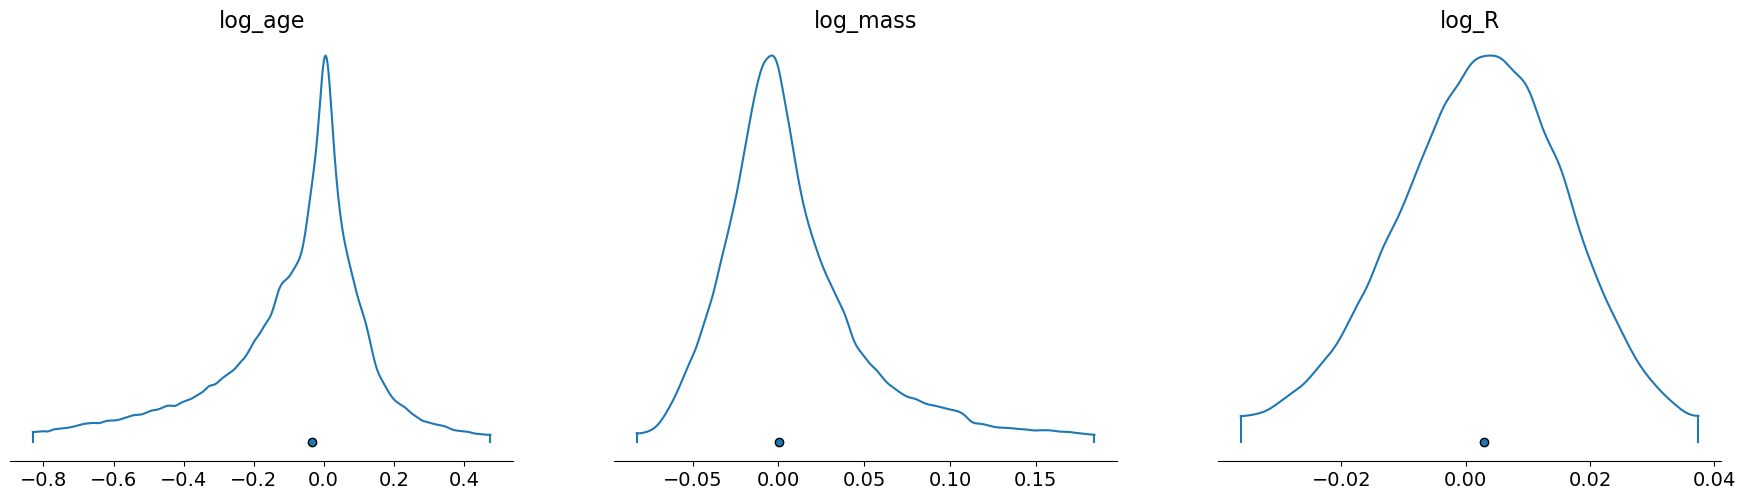

In [38]:
az.plot_density(error, var_names=["log_age", "log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

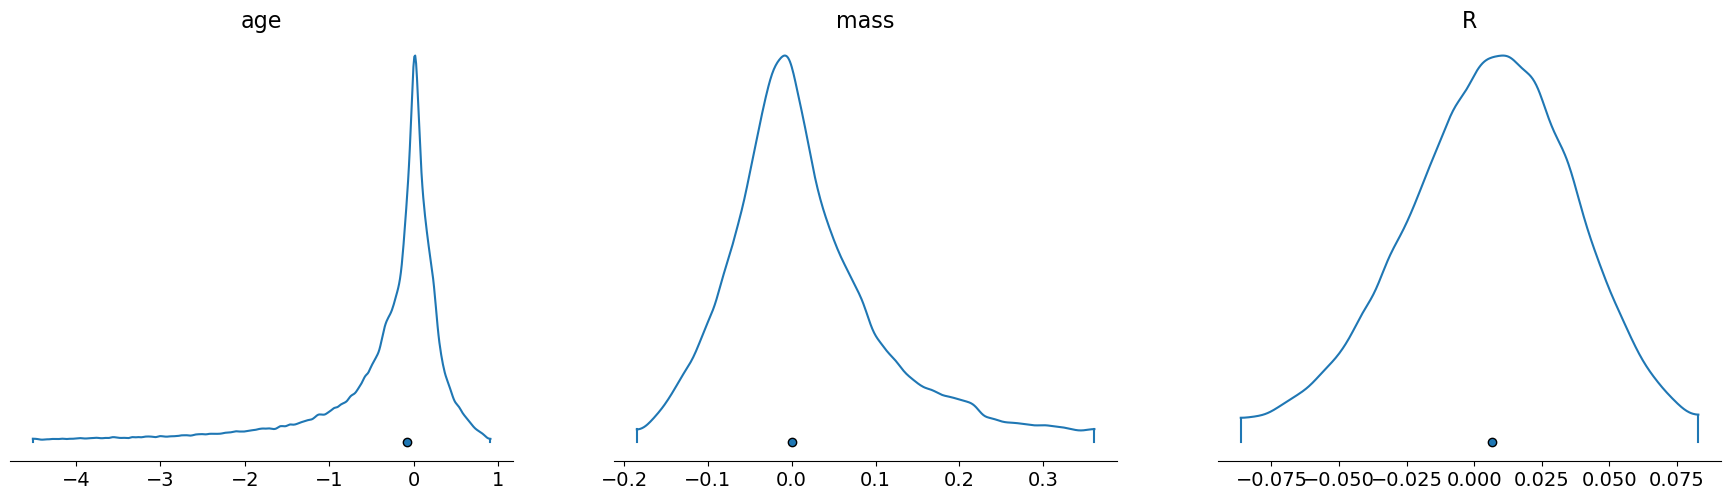

In [39]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

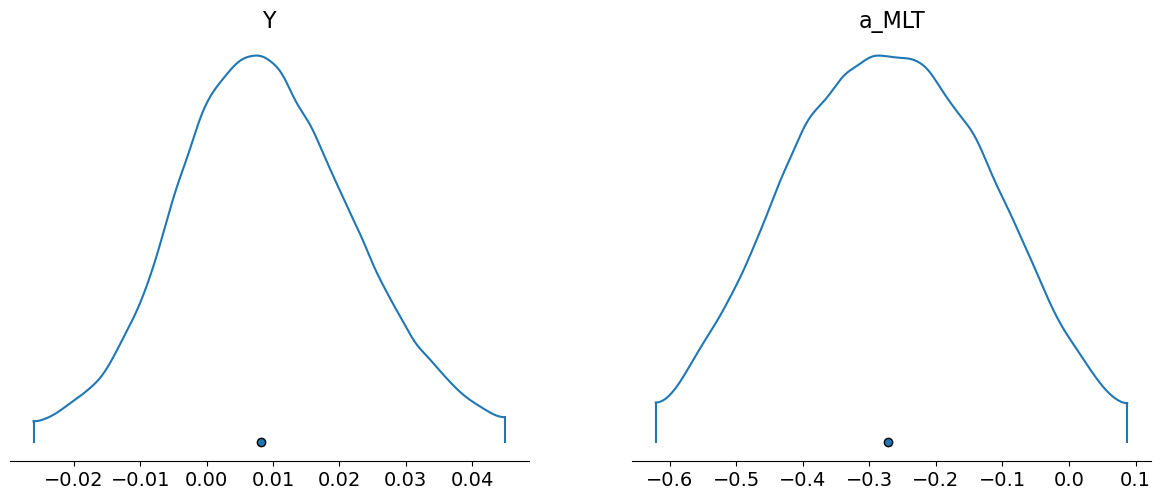

In [40]:
az.plot_density(error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

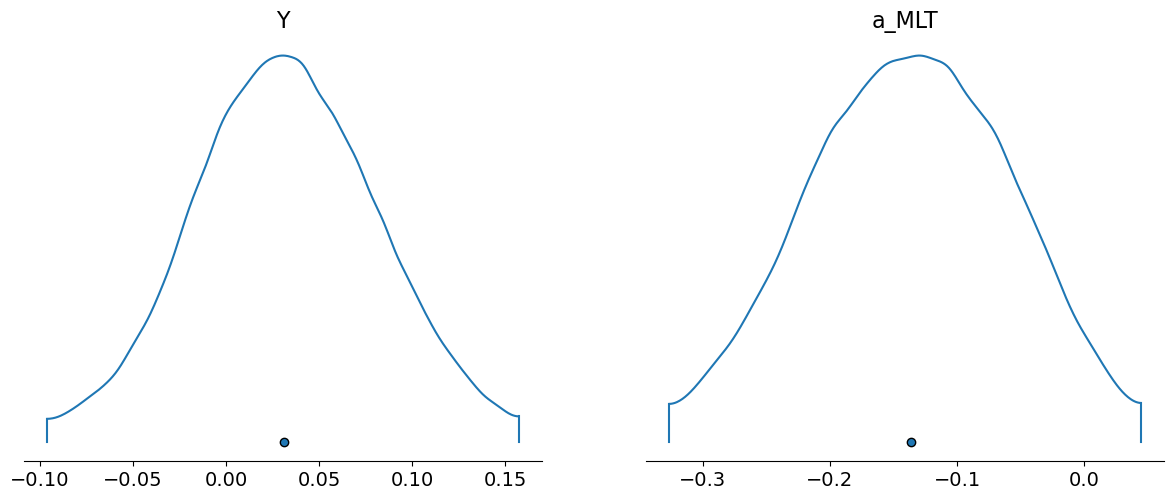

In [41]:
az.plot_density(fractional_error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

In [40]:
Y_decentered = truths["Y"] - truths["dY_dZ"] * truths["Zinit"] - truths["Y_0"]

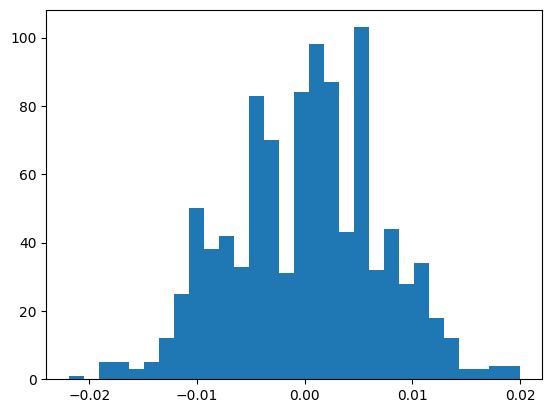

In [44]:
fig, ax = plt.subplots()
ax.hist(Y_decentered, bins=30);

In [43]:
mean = Y_decentered.mean()
sd = Y_decentered.std(ddof=1)
print(mean, sd)

0.000127728485000005 0.0069691380029937135


In [32]:
import numpyro.distributions as dist
import json, os
from celestify import PACKAGEDIR

In [33]:
with open(os.path.join(PACKAGEDIR, "data/emulator_error.json"), "r") as file:
    params = json.loads(file.read())

In [34]:
tril = np.array(params["L_omega"])
y = dist.MultivariateNormal(0.0, scale_tril=tril).sample(rng, sample_shape=(5000,))

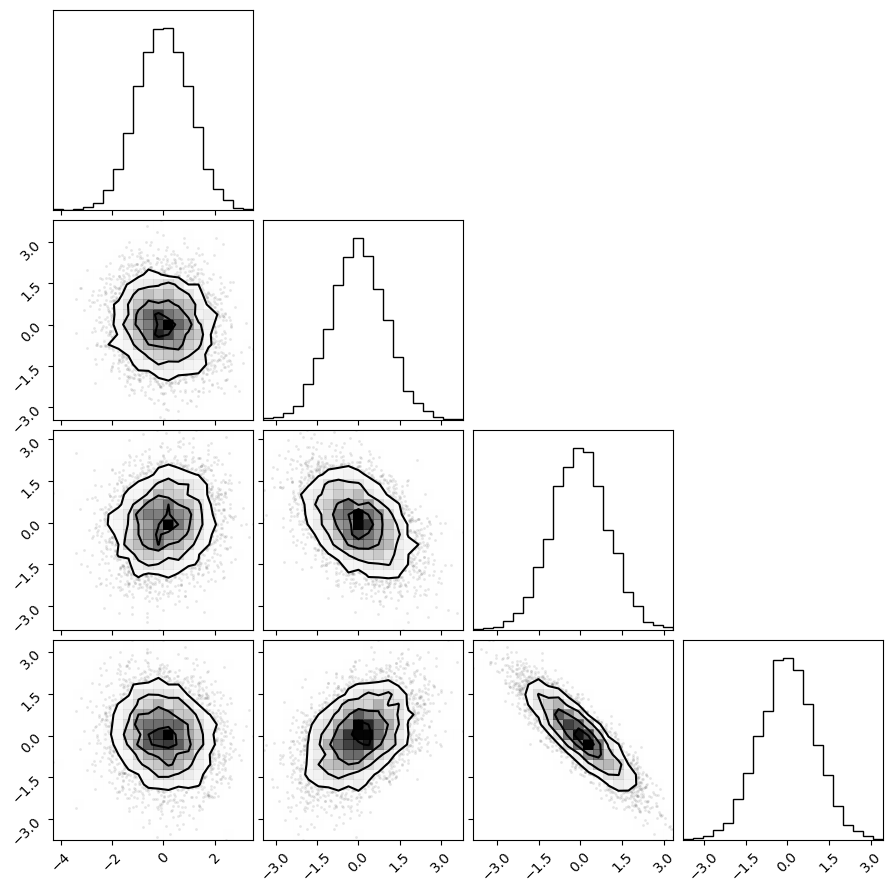

In [35]:
fig = corner(np.array(y))

In [36]:
scale = np.array(np.sqrt(params["theta"]))
df = np.array(params["df"])
precision = dist.Gamma(df/2., df/2.).sample(key, sample_shape=(5000,))

In [37]:
precision.shape

(5000,)

In [38]:
y_rescaled = np.array(params["mu"]) + scale / precision[:, None]**0.5 * y

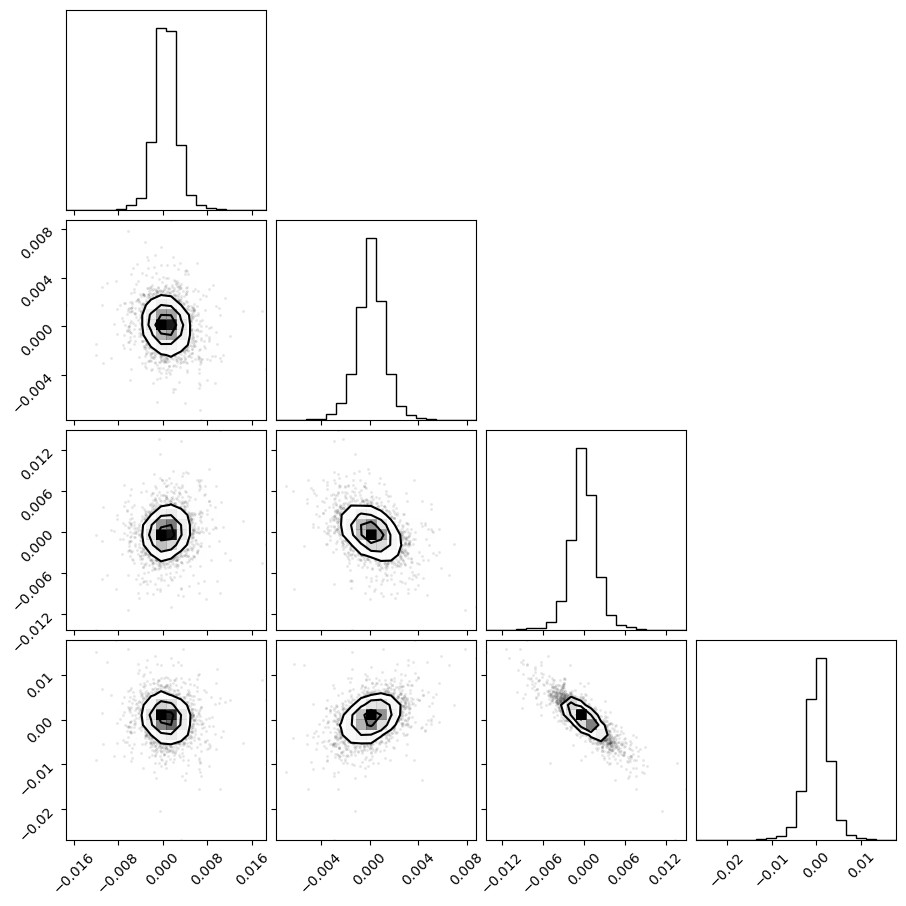

In [39]:
fig = corner(np.array(y_rescaled))

In [40]:
y_rescaled.mean(axis=0)

Array([ 5.96690200e-04,  1.20139316e-04, -6.34780692e-05,  3.25639357e-04],      dtype=float64)

In [41]:
np.quantile(y_rescaled, [.16, .5, .84], axis=0)

array([[-1.23076106e-03, -9.29330125e-04, -1.75329649e-03,
        -2.02208252e-03],
       [ 5.72614796e-04,  1.17620285e-04, -7.35444700e-05,
         3.77296980e-04],
       [ 2.41683728e-03,  1.18239849e-03,  1.64679126e-03,
         2.65793688e-03]])

In [42]:
tril

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-0.10934522,  0.99400383,  0.        ,  0.        ],
       [ 0.1475257 , -0.41157913,  0.8993547 ,  0.        ],
       [-0.12795591,  0.41253936, -0.74895447,  0.50249952]])

In [43]:
scale_tril = scale[:, None] * tril

In [44]:
cov = scale_tril @ scale_tril.T

In [45]:
np.sqrt(16 * cov[1, 1] + 4 * cov[2, 2] + 2 * 4 * 2 * cov[1, 2])

0.0036510590126178043

In [46]:
np.sqrt(16 * cov[1, 1] + 4 * cov[2, 2])

0.0047763392410090965

In [47]:
precision = np.ones(())

In [48]:
cov / precision[..., None, None]

array([[ 2.48329366e-06, -1.60093929e-07,  3.48753274e-07,
        -4.17365098e-07],
       [-1.60093929e-07,  8.63221086e-07, -5.92699039e-07,
         8.15505814e-07],
       [ 3.48753274e-07, -5.92699039e-07,  2.25046979e-06,
        -2.67737399e-06],
       [-4.17365098e-07,  8.15505814e-07, -2.67737399e-06,
         4.28433539e-06]])

In [53]:
covariance = cov[:2, :2]

In [63]:
mean = np.array([0.1, -0.2]) * np.ones((10, 2))
mean

array([[ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2]])

In [114]:
(mean.T * mean.T[:, None]).T * (covariance * np.ones((10, 2, 2)))

array([[[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]],

       [[2.48329366e-08, 3.20187858e-09],
        [3.20187858e-09, 3.45288434e-08]]])

In [100]:
np.swapaxes(mean[..., None], -1, -2).shape

(10, 1, 2)

In [85]:
from jax import vmap

In [88]:
vmap(lambda mean: mean * mean[:, None])(mean[0]).shape #* (np.exp(covariance) - 1)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [73]:
(covariance * np.ones((10, 2, 2))).shape

(10, 2, 2)

In [72]:
(mean * mean[..., None, None]).shape

(10, 2, 10, 2)

In [77]:
mean @ mean.T

array([[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]])

In [78]:
mean

array([[ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2],
       [ 0.1, -0.2]])